In [11]:
!pip install opencv-contrib-python
!pip install opencv-python
!pip install opencv-python-headless==4.1.2.30

In [86]:
import cv2
import matplotlib.pyplot as plt
import numpy as np 
from math import sqrt

## 图像梯度

In [16]:
def filter_image_with_kernel(img: np.array, kernel: np.array) -> np.array:
    """对图像进行卷积运算

    使用参数提供的kernel，对图像进行卷积运算，返回卷积计算结果。我们暂不考虑步长的问题，后面课程到卷积部分会单独实现。

    Args:
        img: 单通道图像，格式为np.array
        kernel: np.array二维数组，这里我们简化问题，先限定kernel的宽和高相等并且为奇数
    
    Return:
        返回卷积运算后的图像

    Raises:
        ValueError: 当传入的数据格式不符合要求时，抛出ValueError异常
    """

    if len(img.shape) != 2:
        #TODO(NighWalker888): 处理多通道输入
        raise ValueError

    if len(kernel.shape) != 2:
        raise ValueError

    h, w = img.shape[:2]
    kernel_h, kernel_w = kernel.shape[:2]

    if kernel_h != kernel_w or kernel_w % 2 == 0:
        #TODO(NighWalker888): 处理不同宽高的kernel，处理宽高存在偶数的情况
        raise ValueError

    filtered_img = np.zeros_like(img)
    # 我们使用0值对图像进行补全(padding)，保证图像卷积运算后尺寸不变
    padding_img = np.zeros((kernel_h - 1 + h, kernel_w - 1 + w))
    padding_img[int(kernel_h / 2 - 1):int(kernel_h / 2 - 1) + h, 
                int(kernel_w / 2 - 1):int(kernel_w / 2 - 1) + w] = img 

    conv = lambda region,kernel: np.sum(region.flatten() * kernel.flatten())  
    
    for row in range(h):
        for col in range(w):
            target_region = padding_img[row:row + kernel_h, col:col + kernel_w]
            filtered_img[row, col] = conv(target_region, kernel)
    
    return filtered_img

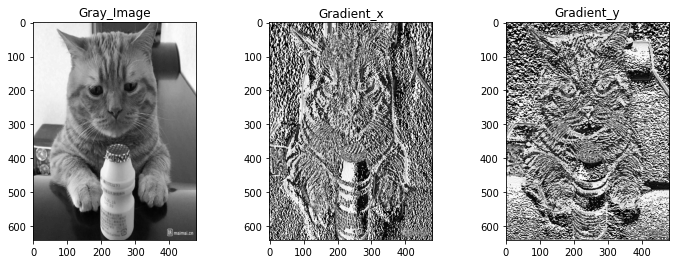

In [20]:
img_gray = cv2.imread("../demo_images/little_cat.jpg", cv2.IMREAD_GRAYSCALE) 

prewitt_kernel_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
prewitt_kernel_y = prewitt_kernel_x.T #矩阵转置

img_grad_x = filter_image_with_kernel(img_gray, prewitt_kernel_x)
img_grad_y = filter_image_with_kernel(img_gray, prewitt_kernel_y)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("Gray_Image")
plt.imshow(img_gray,cmap = 'gray')

plt.subplot(1,3,2)
plt.title("Gradient_x")
plt.imshow(img_grad_x,cmap = 'gray')

plt.subplot(1,3,3)
plt.title("Gradient_y")
plt.imshow(img_grad_y,cmap = 'gray')

plt.show()
# plt.savefig("../course_images/gradient.jpg", dpi = 300)


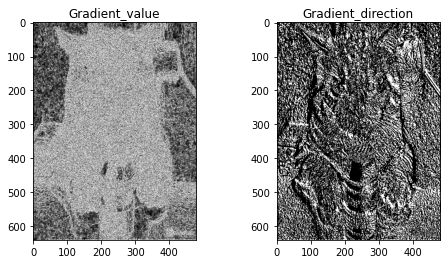

In [29]:
img_grad_value = np.sqrt(img_grad_x ** 2 + img_grad_y ** 2)
img_grad_direct = np.arctan2(img_grad_y, img_grad_x)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Gradient_value")
plt.imshow(img_grad_value.astype(np.uint8),cmap = 'gray')

plt.subplot(1,2,2)
plt.title("Gradient_direction")
plt.imshow(img_grad_direct.astype(np.uint8),cmap = 'gray')

plt.show()
# plt.savefig("../course_images/gradient_attr.jpg", dpi = 300)


## Harris角点检测

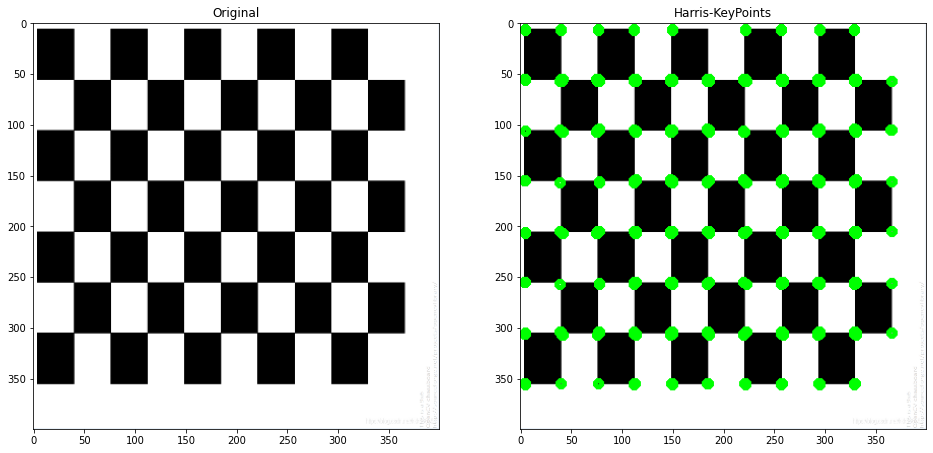

In [70]:
img_bgr = cv2.imread("../demo_images/chess.jpg", cv2.IMREAD_COLOR)
img_bgr = cv2.resize(img_bgr, (400, 400))
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY) 

# blockSize, apertureSize, k为超参数，用法可参考:https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#gac1fc3598018010880e370e2f709b4345 
blockSize = 2
apertureSize = 3
k = 0.04
dst = cv2.cornerHarris(img_gray, blockSize, apertureSize, k)
dst_norm = np.empty(dst.shape, dtype=np.float32)
cv2.normalize(dst, dst_norm, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

# 将Harris角点绘制出
img_bgr_harris = img_bgr.copy()
for i in range(dst_norm.shape[0]):
    for j in range(dst_norm.shape[1]):
        if int(dst_norm[i, j]) > 120:
            cv2.circle(img_bgr_harris, (j, i), 3, (0, 255, 0), 3)

plt.figure(figsize=(16,10))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img_bgr[:,:,::-1]) #[:,:,::-1]通过的numpy的通道翻转，实现BGR转RGB

plt.subplot(1,2,2)
plt.title("Harris-KeyPoints")
plt.imshow(img_bgr_harris[:,:,::-1])
plt.show()
#plt.savefig("../course_images/harris.jpg", dpi = 300)

## SIFT算子

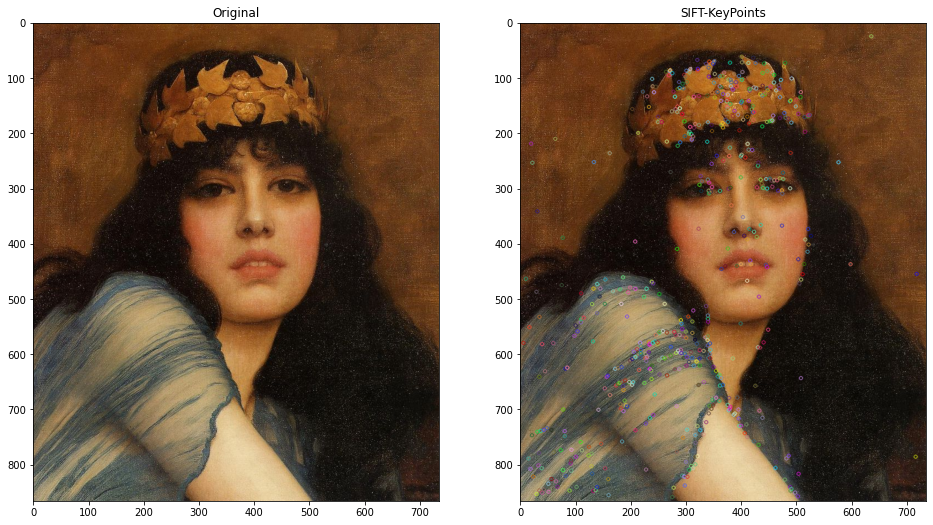

In [61]:
img_bgr = cv2.imread("../demo_images/paint.jpg", cv2.IMREAD_COLOR)
sift = cv2.SIFT_create()
key_point = sift.detect(img_bgr, None)
"""
OpenCV的KeyPoint类型的数据结构依次包含:
    angle: 角度。表示关键点的梯度方向，初值为 -1。
    class_id:分类标签。当需要对图像进行分类时，可以人为设定，初值为 -1。
    octave: 关键点的尺度定位。代表是从DOG金字塔中的哪一层提取的得到的数据。
    pt: 关键点的坐标。
    response: 该关键点的角点程度。
    size: 该关键点的直径大小。
"""
img_bgr_sift=cv2.drawKeypoints(img_bgr, key_point, None)
plt.figure(figsize=(16,10))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img_bgr[:,:,::-1]) #[:,:,::-1]通过的numpy的通道翻转，实现BGR转RGB
#plt.show()
plt.subplot(1,2,2)
plt.title("SIFT-KeyPoints")
plt.imshow(img_bgr_sift[:,:,::-1])
plt.show()
# plt.savefig("../course_images/sift.jpg", dpi = 300)

In [60]:
# 实例sift的compute方法可以根据输入图像和已经提取的SIFT兴趣点计算SIFT特征向量
key_point, sift_feats = sift.compute(img_bgr, key_point) #入参的key_point和返回的key_point数值相同
print(f"SIFT特征向量维度: {sift_feats.shape}")
print(f"第一维结果: {sift_feats[0]}")

SIFT特征向量维度: (667, 128)
第一维结果: [ 22.   2.   0.  12. 140.  14.   2.  10. 146.  22.   1.   6.  36.   4.
   0.  18.  61.   4.   1.  23.  48.   4.   0.   6.   0.   0.   0.   3.
   3.   0.   0.   0.  21.   2.   0.  31. 146.  14.   4.  18. 146.  18.
   1.  11.  36.   5.   2.  52.  84.   6.   1.  55. 146.   3.   0.  10.
   1.   0.   0.  12.  16.   0.   1.   9.  22.  10.   6.  57. 146.  10.
   2.   8. 146.  78.   9.  21.  17.   3.   2.  30.  51.  24.   7.  60.
  98.   2.   2.  24.   8.   1.   1.  25.  16.   1.   2.  29.  21.   3.
   1.  27. 137.  16.   4.  20. 146.  18.   4.   9.   6.   3.   2.  48.
  37.  15.   6.  29.  20.   0.   0.   9.   8.   3.   2.  57.  73.   0.
   0.   4.]


## 兴趣点匹配

In [92]:
def calc_match_keypoints(img_a: np.array, img_b: np.array, similar_thresh: int = 200) -> tuple:
    """使用SIFT描述子计算两张图之间的可匹配兴趣点

    输入两张图像，基于SIFT描述子分别提取特征向量，然后根据L2距离做兴趣点匹配，返回一个存储与元组的匹配结果

    Args:
        img_a: 一张灰度图或者彩色图像
        img_b: 一张灰度图或者彩色图像
        similar_thresh: 匹配的相似度阈值，默认200
    
    Return:
        返回一个元组，元组中存储关键点pair，比如:
        ((ptx_a, ptx'_b), (pty_a, pty'_b), ...)
    """
    sift = cv2.SIFT_create()
    key_point = sift.detect(img_a, None)
    key_point_a, sift_feats_img_a = sift.compute(img_a, key_point)
    key_point = sift.detect(img_b, None)
    key_point_b, sift_feats_img_b = sift.compute(img_b, key_point)

    matched_points = []
    for idx, feat in enumerate(sift_feats_img_a):
        l2_distance = np.sum((feat - sift_feats_img_b)**2, axis = 1)
        min_index = np.argmin(l2_distance)
        min_distance = sqrt(l2_distance[min_index])
        
        if min_distance <= similar_thresh:
            points = (getattr(key_point_a[idx], "pt"), getattr(key_point_b[min_index], "pt"))
            matched_points.append(points)

    return tuple(matched_points)




In [123]:
def plot_matches(img_a: np.array, img_b: np.array, matched_points: tuple) -> None:
    """ 显示一幅带有连接匹配之间连线的图片

    Args: 
        img_a: 一张灰度图或者彩色图像
        img_b: 一张灰度图或者彩色图像
        matched_points: 元组中存储关键点pair，比如:
        ((ptx_a, ptx'_b), (pty_a, pty'_b), ...)
    """
    img_concat = im3 = np.hstack([img_a,img_b])
    img_show = np.vstack((img_concat,img_concat))
    cols1 = img_a.shape[1]
    plt.figure(figsize = (10, 10))
    plt.imshow(img_show[:,:,::-1])
    for pt_a, pt_b in matched_points:
        ax, ay = int(pt_a[0]), int(pt_a[1])
        bx, by = int(pt_b[0]), int(pt_b[1])
        plt.plot([ax, bx + cols1], [ay, by], "c")
    plt.show()
    #plt.savefig("../course_images/sift_match.jpg", dpi = 300)

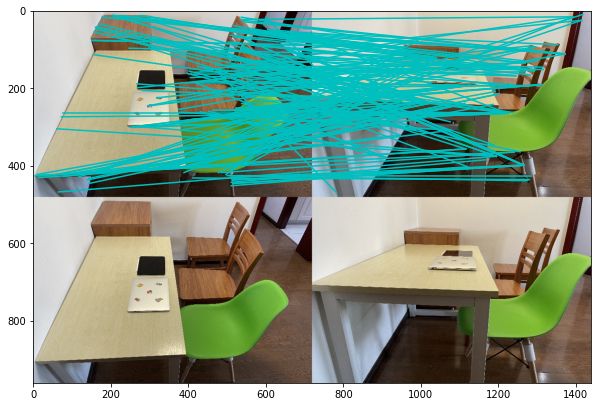

In [124]:
img_bgr_a = cv2.imread("../demo_images/desk_view1.jpg", cv2.IMREAD_COLOR)
img_bgr_b = cv2.imread("../demo_images/desk_view2.jpg", cv2.IMREAD_COLOR)
img_bgr_a = cv2.resize(img_bgr_a, (720, 480))
img_bgr_b = cv2.resize(img_bgr_b, (720, 480))

matched_points = calc_match_keypoints(img_bgr_a, img_bgr_b, similar_thresh = 300)
plot_matches(img_bgr_a, img_bgr_b, matched_points)
